In [ ]:
!pip install pytorch-tabnet optuna

In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tensorflow==2.4.2 deeptables

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itertools import chain, combinations
#import optuna
#cannot import name 'ParamSpec' from 'typing_extensions' (/usr/local/lib/python3.7/dist-packages/typing_extensions.py)


from pytorch_tabnet.tab_model import TabNetClassifier

from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,MinMaxScaler,MaxAbsScaler,RobustScaler
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,f1_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor,XGBClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile

import torch
import torch.nn as nn

from xgboost import plot_importance
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!mkdir aug-tabular-playground

mkdir: cannot create directory ‘aug-tabular-playground’: File exists


In [ ]:
!kaggle competitions download -c tabular-playground-series-aug-2022

  0% 0.00/2.27M [00:00<?, ?B/s]
100% 2.27M/2.27M [00:00<00:00, 192MB/s]


In [ ]:
from zipfile import ZipFile

file_name = "tabular-playground-series-aug-2022.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zipper:
    # printing all the contents of the zip file
    #zipper.printdir()
    zipper.extractall('aug-tabular-playground')
zipper.close()

In [ ]:
df_org=pd.read_csv("/content/aug-tabular-playground/train.csv")

In [ ]:
df_org['attribute_0_material_5'] = np.where(df_org['attribute_0']=='material_5', 1, 0)
df_org['attribute_0_material_7'] = np.where(df_org['attribute_0']=='material_7', 1, 0)

In [ ]:
features = ['attribute_0_material_5','attribute_0_material_7','loading', 'measurement_0', 'measurement_1', 'measurement_2',
                'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
                'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
                'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
                'measurement_15', 'measurement_16', 'measurement_17']
cat_features=['attribute_0_material_5','attribute_0_material_7']
num_features = ['loading', 'measurement_0', 'measurement_1', 'measurement_2',
                'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
                'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
                'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
                'measurement_15', 'measurement_16', 'measurement_17']
cat_features=['attribute_0_material_5','attribute_0_material_7']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_org[features], df_org['failure'], 
                                                    test_size=0.33,
                                                    random_state=2,
                                                    stratify=df_org['failure']) 

In [ ]:
col_pair_list=sum([list(map(list, combinations(features, 2)))], [])
def get_interaction_features_pairs(df_org,col_pair_list):
    X_copy=df_org.copy()
    for col_pair in col_pair_list:
        col1,col2=col_pair
        new_col=f"{col1}_{col2}"
        X_copy[new_col]=X_copy[col1]*X_copy[col2]
    return X_copy

col_triplet_list=sum([list(map(list, combinations(features, 3)))], [])
def get_interaction_features_triplets(df_org,col_triplet_list):
    X_copy=df_org.copy()
    for col_triplet in col_triplet_list:
        col1,col2,col3=col_triplet
        new_col=f"{col1}_{col2}_{col3}"
        X_copy[new_col]=X_copy[col1]*X_copy[col2]*X_copy[col3]
    return X_copy

In [ ]:
N_NEIGHBORS=5
imputer=KNNImputer(n_neighbors=N_NEIGHBORS)
X_train_numpy=imputer.fit_transform(X_train[num_features])
X_test_numpy=imputer.transform(X_test[num_features])

scaler=MinMaxScaler()
X_train_numpy=scaler.fit_transform(X_train_numpy)
X_test_numpy=scaler.transform(X_test_numpy)

X_train_imputed=pd.concat([X_train[cat_features].copy().reset_index(drop=True),
                            pd.DataFrame(X_train_numpy,columns=num_features)],
                            axis=1)

X_test_imputed=pd.concat([X_test[cat_features].copy().reset_index(drop=True),
                            pd.DataFrame(X_test_numpy,columns=num_features)],
                            axis=1)



X_train_new_feats=get_interaction_features_pairs(X_train_imputed,col_pair_list)
X_test_new_feats=get_interaction_features_pairs(X_test_imputed,col_pair_list)

X_train_new_feats=get_interaction_features_triplets(X_train_new_feats,col_triplet_list)
X_test_new_feats=get_interaction_features_triplets(X_test_new_feats,col_triplet_list)

selector = SelectKBest(mutual_info_classif, k=720)
X_train_reduced = selector.fit_transform(X_train_new_feats, y_train)
X_test_reduced = selector.transform(X_test_new_feats)

cols = selector.get_support(indices=True)
selected_columns = X_train_new_feats.iloc[:,cols].columns.tolist()

#X_train_reduced_df=pd.DataFrame(X_train_reduced,columns=selected_columns)

#X_test_reduced_df=pd.DataFrame(X_test_reduced,columns=selected_columns)

scaler2=MinMaxScaler()
X_train_numpy=scaler2.fit_transform(X_train_reduced)
X_test_numpy=scaler2.transform(X_test_reduced)

X_train_scaled = pd.DataFrame(X_train_numpy,columns=selected_columns)

X_test_scaled = pd.DataFrame(X_test_numpy,columns=selected_columns)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()


Text(0, 0.5, 'cumulative explained variance')

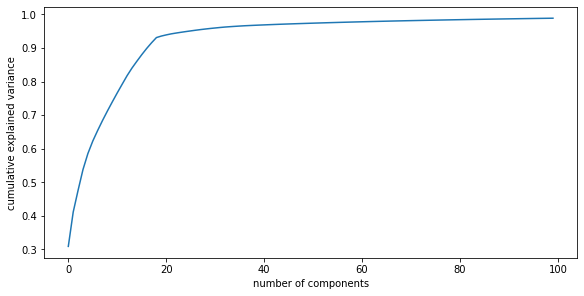

In [ ]:
from sklearn.decomposition import PCA
# initializing the PCA transformer and

pca = PCA(n_components=100).fit(X_train_scaled)

fig = plt.figure(constrained_layout=True, figsize=(8, 4))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
pca60=PCA(n_components=60).fit(X_train_scaled)
X_train_pca = pca60.fit_transform(X_train_scaled)

X_test_pca = pca60.transform(X_test_scaled)

In [ ]:
def grid_search(param_grid,X,y,random_st):
    clf = LogisticRegression()
    kf = StratifiedKFold(n_splits=5,random_state=random_st,shuffle=True)
    for train_index,test_index in kf.split(X,y):
          
        grid_search =GridSearchCV(clf, 
                                  param_grid = param_grid, 
                                  scoring='roc_auc', 
                                  cv=[(train_index, test_index)])
        grid_search.fit(X, y)
        
        y_pr=grid_search.decision_function(X)
        roc_auc=roc_auc_score(y, y_pr)
        #rand_reg.fit(X[feature_list], y)
        best_params = grid_search.best_params_
        print("Best params:", best_params)
        best_score = grid_search.best_score_
        print("Best score:", best_score)

        print("roc_auc:", roc_auc)

In [ ]:
param_grid = [    
    {'penalty' : ['l1'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear'],
    'max_iter' : [100, 250,500,750,1000]
    }
]
grid_search(param_grid=param_grid,
            X=X_train_pca,
            y=y_train,
            random_st=1)


Best params: {'C': 0.03359818286283781, 'max_iter': 250, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.5881770145310435
roc_auc: 0.5950253494025323
Best params: {'C': 0.012742749857031334, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.5883265288040602
roc_auc: 0.5931810144888197
Best params: {'C': 0.08858667904100823, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.594377320770207
roc_auc: 0.597278577266668
Best params: {'C': 0.012742749857031334, 'max_iter': 250, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.610740238214293
roc_auc: 0.5931810898885893
Best params: {'C': 0.615848211066026, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.5853258751356704
roc_auc: 0.6009116397640288


In [ ]:
param_grid = [    
    {'penalty' : ['l1'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear'],
    'max_iter' : [100, 250,500,750,1000]
    }
]
grid_search(param_grid=param_grid,
            X=X_train_pca,
            y=y_train,
            random_st=2)

Best params: {'C': 0.03359818286283781, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.5863052781740371
roc_auc: 0.595024482305182
Best params: {'C': 0.004832930238571752, 'max_iter': 250, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.5840204234847453
roc_auc: 0.5900598787270106
Best params: {'C': 0.08858667904100823, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.602436246124293
roc_auc: 0.5972786715163798
Best params: {'C': 0.08858667904100823, 'max_iter': 750, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.6003220742448527
roc_auc: 0.597279010815343
Best params: {'C': 0.03359818286283781, 'max_iter': 250, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.5952491928114385
roc_auc: 0.5950241241562766


In [ ]:
model = LogisticRegression(C=0.04, penalty='l1', solver='liblinear')
model.fit(X_train_pca, y_train)
coef=model.coef_[0]
#imp_features=list(pd.Series(X_train_pca.columns)[list(coef!=0)])
#print(imp_features)
preds=model.predict_proba(X_test_pca)[:,1]
roc_auc=roc_auc_score(y_test,preds)
print(roc_auc)

0.5830870675911279


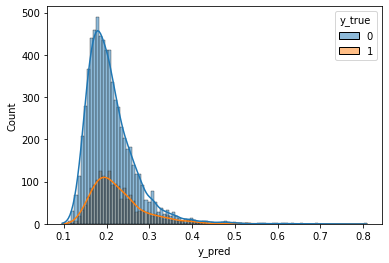

In [ ]:
df_check=pd.DataFrame({'y_pred':preds.tolist(),
                       'y_true':y_test.tolist() })

sns.histplot(data=df_check,x='y_pred', bins=100, kde=True, hue='y_true', legend=True)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=1001, perplexity=30, method='barnes_hut', n_iter=1000, verbose=1)
X_tsne = tsne.fit_transform(X_train_pca) # this will either fail or take a while (most likely overnight)
X_tsne_df=pd.DataFrame({'V1':X_tsne[:,0],
                        'V2':X_tsne[:,1],
                        'y':y_train.tolist()})



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17801 samples in 0.001s...
[t-SNE] Computed neighbors for 17801 samples in 8.020s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17801
[t-SNE] Computed conditional probabilities for sample 2000 / 17801
[t-SNE] Computed conditional probabilities for sample 3000 / 17801
[t-SNE] Computed conditional probabilities for sample 4000 / 17801
[t-SNE] Computed conditional probabilities for sample 5000 / 17801
[t-SNE] Computed conditional probabilities for sample 6000 / 17801
[t-SNE] Computed conditional probabilities for sample 7000 / 17801
[t-SNE] Computed conditional probabilities for sample 8000 / 17801
[t-SNE] Computed conditional probabilities for sample 9000 / 17801
[t-SNE] Computed conditional probabilities for sample 10000 / 17801
[t-SNE] Computed conditional probabilities for sample 11000 / 17801
[t-SNE] Computed conditional probabilities for sample 12000 / 17801
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.960541
[t-SNE] KL divergence after 1000 iterations: 3.711835


KeyError: ignored

<Figure size 720x720 with 0 Axes>

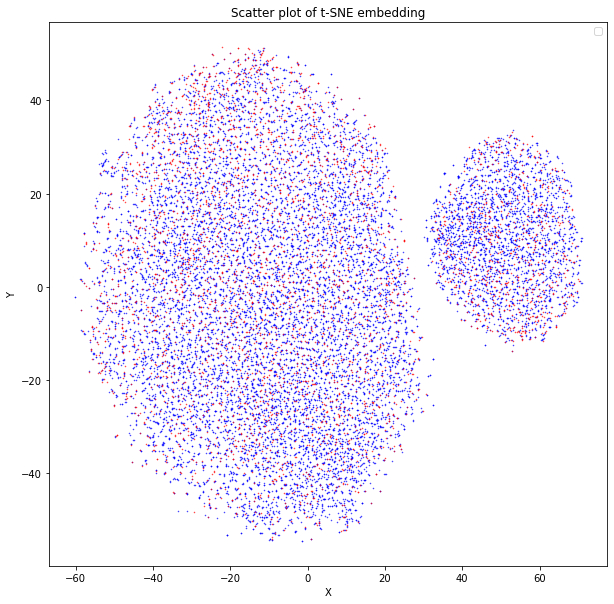

In [ ]:
plt.figure(2, figsize=(10, 10))
colors=['blue','red']
for color, i  in zip(colors, [0, 1] ):
        plt.scatter(X_tsne_df.loc[X_tsne_df['y'] == i, 'V1'], X_tsne_df.loc[X_tsne_df['y'] == i, 'V2'], color=color, s=1,
                                    alpha=.8, marker='.')
        plt.legend(loc='best', shadow=False, scatterpoints=3)
        plt.title('Scatter plot of t-SNE embedding')
        plt.xlabel('X')
        plt.ylabel('Y')

# plt.savefig('t-SNE-porto-01.png', dpi=150)
plt.show()

In [ ]:
pca_col_list=[]
for i in range(60):
    pca_col_list.append(f"V{i}")

In [ ]:
from sklearn.cluster import KMeans

X_train_pca_df=pd.DataFrame(X_train_pca,columns=pca_col_list)
X_test_pca_df=pd.DataFrame(X_test_pca,columns=pca_col_list)
kmeans = KMeans(n_clusters=5)
X_train_pca_df["Cluster"] = kmeans.fit_predict(X_train_pca_df)

X_test_pca_df["Cluster"] = kmeans.predict(X_test_pca_df)

X_train_pca_df["target"]=y_train.copy()
X_test_pca_df["target"]=y_test.copy()



In [ ]:
#X_train_pca_df.groupby(['Cluster', 'target'])['V0'].count()
#X_train_pca_df.groupby(['Cluster'])['target'].count()

#X_train_pca_df.groupby(['Cluster', 'target']).agg({'total': 'sum'})
#X_train_pca_df.groupby(['Cluster']).agg({'total': 'sum'})

X_train_pca_df.groupby(['Cluster', 'target']).agg({'target': 'count'}).div(X_train_pca_df.groupby(['Cluster']).agg({'target': 'count'}), level='Cluster') * 100

target
Cluster target           
0       0.0     77.912212
        1.0     22.087788
1       0.0     80.147378
        1.0     19.852622
2       0.0     78.610297
        1.0     21.389703
3       0.0     78.527895
        1.0     21.472105
4       0.0     79.131007
        1.0     20.868993

In [ ]:
features_to_bin = ['measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
                'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
                'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
                'measurement_15', 'measurement_16', 'measurement_17','loading']

QUANTILE_BINS=800
class BinFeatures(TransformerMixin):
    def __init__(self):
         None
    def fit(self, X,y=None):
         self.bins_dict={}
         for col in features_to_bin:
             q, bins = pd.qcut(X[col], QUANTILE_BINS, retbins=True)
             bins[0]=-np.Inf
             bins[len(bins)-1]=np.Inf
             self.bins_dict[col]=bins
         return self
    def transform(self, X, y=None):
        df=pd.DataFrame()
        X_copy=X.copy()
        for col in features_to_bin:
            col_bins=self.bins_dict[col]
            bin_labels=np.arange(0,len(col_bins)-1)
            new_col=f"{col}_bin"
            #X[new_col]=pd.qcut(X[col].values, QUANTILE_BINS).codes +1
            df[new_col] = pd.cut(X_copy[col], col_bins, labels=bin_labels,right=False).astype('int')
        return df

In [ ]:
col_pair_list=sum([list(map(list, combinations(features, 2)))], [])

class InteractionFeatures(TransformerMixin):
    def __init__(self):
        None
    def fit(self, X,y=None):
        return self
    def transform(self, X, y=None):
        df=pd.DataFrame()
        #X_copy=X.copy()
        for col_pair in col_pair_list:
            col1,col2=col_pair
            new_col=f"{col1}_{col2}"
            df[new_col]=X[col1]*X[col2]
        return df

In [ ]:
N_NEIGHBORS=5
imputer=KNNImputer(n_neighbors=N_NEIGHBORS)
X_train_numpy=imputer.fit_transform(X_train[num_features])
X_test_numpy=imputer.transform(X_test[num_features])

scaler=MinMaxScaler()
X_train_numpy=scaler.fit_transform(X_train_numpy)
X_test_numpy=scaler.transform(X_test_numpy)

X_train_imputed=pd.concat([X_train[cat_features].copy().reset_index(drop=True),
                            pd.DataFrame(X_train_numpy,columns=num_features)],
                            axis=1)

X_test_imputed=pd.concat([X_test[cat_features].copy().reset_index(drop=True),
                            pd.DataFrame(X_test_numpy,columns=num_features)],
                            axis=1)

itf=InteractionFeatures()

Xtrain_2feat=itf.fit_transform(X_train_imputed)
Xtest_2feat=itf.transform(X_test_imputed)

selector = SelectKBest(mutual_info_classif, k=20)
X_train_reduced = selector.fit_transform(Xtrain_2feat, y_train)
X_test_reduced = selector.transform(Xtest_2feat)

cols = selector.get_support(indices=True)
selected_columns = Xtrain_2feat.iloc[:,cols].columns.tolist()

bf=BinFeatures()
Xtrain_binfeat=bf.fit_transform(X_train_imputed[num_features])
Xtest_binfeat=bf.transform(X_test_imputed[num_features])



X_train_transformed=pd.concat([pd.DataFrame(X_train_reduced,columns=selected_columns).reset_index(drop=True),
                               Xtrain_binfeat.reset_index(drop=True)],
                              axis=1)


X_test_transformed=pd.concat([pd.DataFrame(X_test_reduced,columns=selected_columns).reset_index(drop=True),
                               Xtest_binfeat.reset_index(drop=True)],
                              axis=1)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [ ]:
X_train_transformed['measurement_16_bin'].dtypes

dtype('int64')

In [ ]:
X_train_transformed.columns

Index(['attribute_0_material_5_measurement_6', 'loading_measurement_0',
       'loading_measurement_3', 'loading_measurement_5',
       'loading_measurement_6', 'loading_measurement_7',
       'loading_measurement_8', 'loading_measurement_9',
       'loading_measurement_11', 'loading_measurement_12',
       'loading_measurement_13', 'loading_measurement_15',
       'loading_measurement_16', 'loading_measurement_17',
       'measurement_0_measurement_3', 'measurement_0_measurement_11',
       'measurement_0_measurement_13', 'measurement_2_measurement_15',
       'measurement_5_measurement_10', 'measurement_7_measurement_11',
       'measurement_3_bin', 'measurement_4_bin', 'measurement_5_bin',
       'measurement_6_bin', 'measurement_7_bin', 'measurement_8_bin',
       'measurement_9_bin', 'measurement_10_bin', 'measurement_11_bin',
       'measurement_12_bin', 'measurement_13_bin', 'measurement_14_bin',
       'measurement_15_bin', 'measurement_16_bin', 'measurement_17_bin',
       'lo

In [ ]:
def grid_search(params,X,y, clf=XGBClassifier(scale_pos_weight=4)):

    kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
    for train_index,test_index in kf.split(X,y):
          
          clf_grid = GridSearchCV(clf, 
                                   params, 
                                   scoring='roc_auc', 
                                   cv=[(train_index, test_index)])
          clf_grid.fit(X, y)
          best_params = clf_grid.best_params_
          print("Best params:", best_params)
          best_score = clf_grid.best_score_
          print("Best score:", best_score)

In [ ]:
grid_search(params={'max_depth':[4,5,6,7,8,9],
                    'min_child_weight':[1,2,3,4],
                    'n_estimators':[100,200,300,400,500,600]},

                    X=X_train_transformed,y=y_train)



Best params: {'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100}
Best score: 0.5677085198160017
Best params: {'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100}
Best score: 0.562926304190971
Best params: {'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100}
Best score: 0.5730909183451774
Best params: {'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100}
Best score: 0.5861115025371477
Best params: {'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100}
Best score: 0.5656866039452917


In [ ]:
grid_search(params={'max_depth':[6,7,8],
                    'min_child_weight':[2,3,4],
                    'subsample':[0.8,0.9,1],
                    'colsample_bytree':[0.5,0.6,0.7,0.8,0.9],
                    'colsample_bylevel':[0.7, 0.8,0.9],
                    'colsample_bynode':[0.8, 0.9, 1],
                     'n_estimators':[200,300,400,500,600],
                    #'learning_rate':[0.05, 0.1, 0.2, 0.3, 0.4],
                    #'gamma':[0, 0.1, 0.5, 1, 2, 5]},
            X=X_train_transformed,y=y_train)

KeyboardInterrupt: ignored

In [ ]:
X_train.head()

,attribute_0_material_5,attribute_0_material_7,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
22543,0,1,125.70,4,24,4,16.225,10.940,16.733,15.485,...,17.838,11.159,14.858,19.329,11.550,15.354,15.702,NaN,17.838,379.696
5392,1,0,105.34,3,5,5,18.142,11.201,17.658,17.813,...,18.734,12.800,16.886,17.209,NaN,15.647,15.288,15.988,17.448,876.331
3239,0,1,141.06,11,10,3,NaN,12.276,17.754,18.272,...,18.438,12.225,15.649,20.085,12.643,14.704,17.548,15.129,16.840,715.104
17322,0,1,142.93,3,9,6,19.124,10.585,17.703,17.519,...,17.061,NaN,17.219,20.981,10.479,17.047,16.276,12.610,17.622,678.851
6443,1,0,83.18,10,7,2,17.066,11.927,17.564,16.635,...,20.152,12.072,16.840,19.184,12.993,16.820,15.737,19.548,21.562,719.858


In [ ]:
clf = TabNetClassifier(
    n_d=24, n_a=24)

Device used : cpu


In [ ]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [ ]:
clf.fit(
    X_train=X_train_pca, y_train=y_train.values,
    eval_set=[(X_train_pca, y_train.values), (X_test_pca, y_test.values)],
    eval_name=['train', 'test'],
    max_epochs=max_epochs, patience=100,
    batch_size=5000, virtual_batch_size=512,
)

epoch 0  | loss: 0.83741 | train_auc: 0.49177 | test_auc: 0.49467 |  0:00:02s
epoch 1  | loss: 0.64396 | train_auc: 0.5026  | test_auc: 0.50692 |  0:00:04s
epoch 2  | loss: 0.57442 | train_auc: 0.50876 | test_auc: 0.52422 |  0:00:05s
epoch 3  | loss: 0.55348 | train_auc: 0.50424 | test_auc: 0.51755 |  0:00:07s
epoch 4  | loss: 0.54218 | train_auc: 0.5073  | test_auc: 0.51867 |  0:00:09s
epoch 5  | loss: 0.53165 | train_auc: 0.51735 | test_auc: 0.52175 |  0:00:11s
epoch 6  | loss: 0.52492 | train_auc: 0.52678 | test_auc: 0.52211 |  0:00:13s
epoch 7  | loss: 0.52267 | train_auc: 0.53332 | test_auc: 0.52682 |  0:00:15s
epoch 8  | loss: 0.51986 | train_auc: 0.53488 | test_auc: 0.5276  |  0:00:17s
epoch 9  | loss: 0.51851 | train_auc: 0.54321 | test_auc: 0.52924 |  0:00:19s
epoch 10 | loss: 0.51544 | train_auc: 0.55215 | test_auc: 0.53072 |  0:00:20s
epoch 11 | loss: 0.51398 | train_auc: 0.55924 | test_auc: 0.53414 |  0:00:22s
epoch 12 | loss: 0.51161 | train_auc: 0.56239 | test_auc: 0.5348